# Imports and Setup

In [ ]:
%run modules/helpers.py
import helpers as h
import modules.helpers
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd
import importlib
import sys
from zeeman import ZeemanLab

importlib.reload(modules.helpers)

plt.style.use(['seaborn-paper','style/science'])

%config InlineBackend.figure_format = 'svg' # png, retina also are available

# Plot the Data and Peak Fitting

Text(0.5, 1.0, 'Gray value vs measured distance from center')

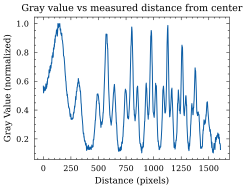

In [ ]:
df = pd.read_csv("data/ImageJ/50_8.csv", delimiter=',')
peaks = find_peaks(df['Gray_Value'], height=(16, None), distance=30)[0]

peak_ys = df['Gray_Value'].to_numpy()[peaks] / max(df['Gray_Value'])
plt.plot(df['Distance_(pixels)'], df['Gray_Value']/max(df['Gray_Value']))
#plt.plot(peaks, peak_ys, 'x')
plt.xlabel('Distance (pixels)')
plt.ylabel('Gray Value (normalized)')
plt.title('Gray value vs measured distance from center')

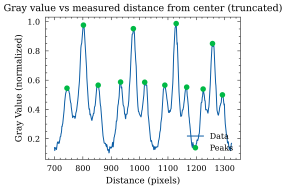

In [ ]:
ys_zoomed = df['Gray_Value'].to_numpy()[700:1325] / max(df['Gray_Value'])
xs_zoomed = df['Distance_(pixels)'].to_numpy()[700:1325]

plt.plot(xs_zoomed, ys_zoomed, label='Data')
plt.plot(peaks[14:26], peak_ys[14:26], 'o', label='Peaks')
plt.xlabel('Distance (pixels)')
plt.ylabel('Gray Value (normalized)')
plt.title('Gray value vs measured distance from center (truncated)')
plt.legend(loc='lower right')

# Compute the Change in Wavenumber and the Magnetic Field

In [ ]:
square_rs = peaks[14:26]**2 # Only peaks that are in the truncated data shown in the cell above
V_B = 50.8 #mV - Voltage from the power supply
B, B_err = ZeemanLab().convert_with_error(V_B, 0.05) #compute the Magnetic Field
delta_nu, sigma_delta_nu = ZeemanLab().compute_delta_nu(square_rs) #Getting the change in wavenumber from the peaks
print("Change in wavenumber = {:.1f} +/- {:.1f} m^-1".format(delta_nu, sigma_delta_nu))
print("B = {:.0f} +/- {:.0f} mT".format(B, B_err))

Change in wavenumber = 34.5 +/- 1.1 m^-1
B = 105 +/- 1 mT


# Reading in the rest of the data and finding peaks

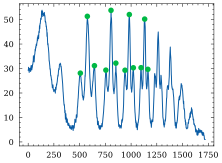

In [ ]:
data_29 = pd.read_csv('data/ImageJ/29_4.csv', delimiter=',')
data_35 = pd.read_csv('data/ImageJ/34_9.csv', delimiter=',')
data_40 = pd.read_csv('data/ImageJ/40_0.csv', delimiter=',')
data_46 = pd.read_csv('data/ImageJ/45_5.csv', delimiter=',')

peaks_29 = find_peaks(data_29['Gray_Value'], height=(16, None), distance=20)[0][14:27]
peaks_29 = np.delete(peaks_29, 3)

peaks_35 = find_peaks(data_35['Gray_Value'], height=(16, None), distance=20)[0][12:24]

peaks_40 = find_peaks(data_40['Gray_Value'], height=(16, None), distance=15)[0][17:33]
peaks_40 = np.delete(peaks_40, [1, 3, 6, 8])

peaks_46 = find_peaks(data_46['Gray_Value'], height=(16, None), distance=15)[0][15:33]
peaks_46 = np.delete(peaks_46, [1, 2, 4, 7, 9, 16])

plt.plot(data_46['Distance_(pixels)'], data_46['Gray_Value'])
plt.plot(peaks_46, data_46['Gray_Value'][peaks_46], 'o')

## Analyzing the data for each magnetic field

Text(0, 0.5, 'Change in wavenumber (1/m)')

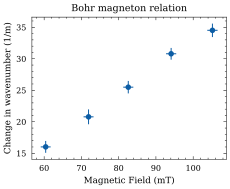

In [ ]:
delta_nu_29, sigma_delta_nu_29 = ZeemanLab().compute_delta_nu(peaks_29**2)
delta_nu_35, sigma_delta_nu_35 = ZeemanLab().compute_delta_nu(peaks_35**2)
delta_nu_40, sigma_delta_nu_40 = ZeemanLab().compute_delta_nu(peaks_40**2)
delta_nu_46, sigma_delta_nu_46 = ZeemanLab().compute_delta_nu(peaks_46**2)

B1, sigma_B1 = ZeemanLab().convert_with_error(29.4, 0.05)
B2, sigma_B2 = ZeemanLab().convert_with_error(34.9, 0.05)
B3, sigma_B3 = ZeemanLab().convert_with_error(40.0, 0.05)
B4, sigma_B4 = ZeemanLab().convert_with_error(45.5, 0.05)

ys = np.array([delta_nu_29, delta_nu_35, delta_nu_40, delta_nu_46, delta_nu])
err_ys = np.array([sigma_delta_nu_29, sigma_delta_nu_35, sigma_delta_nu_40, sigma_delta_nu_46, sigma_delta_nu])
xs = np.array([B1, B2, B3, B4, B])
err_xs = np.array([sigma_B1, sigma_B2, sigma_B3, sigma_B4, B_err])

plt.errorbar(xs, ys, xerr=err_xs, yerr=err_ys, fmt='o', capsize=3)
plt.title('Bohr magneton relation')
plt.xlabel('Magnetic Field (mT)')
plt.ylabel('Change in wavenumber (1/m)')

Text(0, 0.5, 'Change in wavenumber (1/m)')

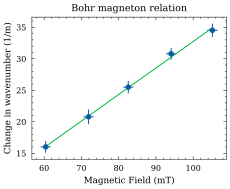

In [ ]:
f = lambda x, a, b: a*x + b
fit, cov = curve_fit(f, xs/1000, ys)

plt.errorbar(xs, ys, xerr=err_xs, yerr=err_ys, fmt='o', capsize=3)
plt.plot(xs, f(xs/1000, *fit))
plt.title('Bohr magneton relation')
plt.xlabel('Magnetic Field (mT)')
plt.ylabel('Change in wavenumber (1/m)')

Text(0, 0.5, 'Residuals (1/m)')

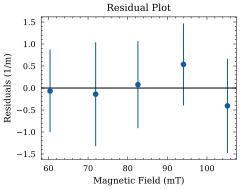

In [ ]:
plt.errorbar(xs, ys-f(xs/1000, *fit), yerr=err_ys, fmt='o', capsize=3)
plt.axhline(y=0, color='black')
plt.title('Residual Plot')
plt.xlabel('Magnetic Field (mT)')
plt.ylabel('Residuals (1/m)')

In [ ]:
fit_errs = np.sqrt(np.diag(cov))
dof = len(xs) - 2
reduced_chi2 = (1/dof)*np.sum((ys - f(xs/1000, *fit))**2/err_ys**2)
print("Reduced Chi2 = {:.3f}".format(reduced_chi2))
print("a = {:.0f} +/- {:.0f}, b = {:.1f} +/- {:.1f}".format(fit[0], fit_errs[0], fit[1], fit_errs[1]))

Reduced Chi2 = 0.167
a = 421 +/- 11, b = -9.3 +/- 1.0


In [ ]:
hc = 3.16152677e-26 # just h_bar*c
mu_B = hc*fit[0] / 2
sigma_mu_B = hc*fit_errs[0] / 2
print("mu_B = ({:.1f} +/- {:.1f})x10^-24 J T^-1".format(mu_B*1e24, sigma_mu_B*1e24))

mu_B = (6.7 +/- 0.2)x10^-24 J T^-1


In [ ]:
dof

3

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ecbd92d-6b4a-45b7-a31d-2b1feb49da8f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>